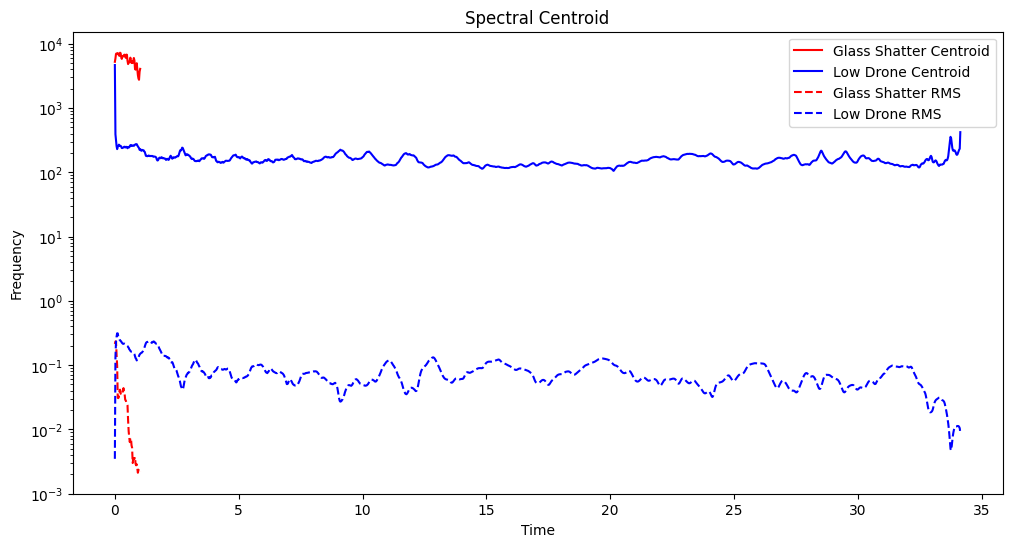

In [11]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

y, sr = librosa.load(r'../data/Glass Shatter.wav')
y1, sr1 = librosa.load(r'../data/Low Drone.wav')

#get the frames
centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
centroids1 = librosa.feature.spectral_centroid(y=y1, sr=sr1)[0]
frames = range(len(centroids))
frames1 = range(len(centroids1))
t = librosa.frames_to_time(frames)
t1 = librosa.frames_to_time(frames1)

#rms 
rms = librosa.feature.rms(y=y)[0]
rms1 = librosa.feature.rms(y=y1)[0]


#create visuals
plt.figure(figsize=(12,6))
plt.semilogy(t, centroids, label='Glass Shatter Centroid', color='Red')
plt.semilogy(t1, centroids1, label='Low Drone Centroid', color='Blue')
plt.semilogy(t, rms, label='Glass Shatter RMS', color='Red', linestyle='--')
plt.semilogy(t1, rms1, label='Low Drone RMS', color='Blue', linestyle ='--')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectral Centroid')
plt.legend()
plt.show()